# Time Series Forecasting (Continued)
**Project**: M5 Project 5
**Author**: Jacob Buysse

In this project we will be performing regression modeling on flights from the New York area and adding complimentary data to see how it improves perfromance.

In this notebook we will be using...

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib as plt
import seaborn as sns
import scipy.sparse as sp
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

We will configure our plots for readable labels, high resolution, and automatic layout.

In [2]:
plt.rc("axes", labelsize=18)
plt.rc("figure", dpi=150, autolayout=True)

## Part IV

Now we will use the entire dataset to train a Ridge model (gave the best predictions) and forecast the next year (2018).  We will need to get the features for 2018 like we did when cleaning the original data.

In [3]:
df = pd.read_feather('./counts.feather')
first_date = datetime.datetime(year=2013, month=1, day=1)
df['day_serial'] = df.date.apply(lambda value: (value - first_date).days + 1)

We will one hot encode the categorical features.

In [4]:
hot_enc = OneHotEncoder()
cat_features = ["month", "weekday"]
hot_enc.fit(df[cat_features])
train_hot = hot_enc.transform(df[cat_features])

We will scale the numeric features.

In [5]:
scaler = StandardScaler()
num_features = ["year", "doy", "PRCP", "SNOW", "SNWD", "TMAX", "TMIN", "day_serial"]
scaler.fit(df[num_features])
train_num = scaler.transform(df[num_features])

Next we will collect our bool features.

In [6]:
bool_features = ["weekend", "leapday"] + df.columns[df.columns.str.contains("holiday_")].values.tolist()
train_bool = df[bool_features]

And finally we combined all of the datasets into X,y for train and test.

In [7]:
train_X = sp.hstack((train_hot, train_num, train_bool))
train_y = df['count'].values
print(f"Train X {train_X.shape}, y {len(train_y)}")

Train X (1826, 155), y 1826


Now we will train our model on the entire known dataset.

In [8]:
model = Ridge(random_state=777)
model.fit(train_X, train_y)

Ridge(random_state=777)

Now we need to construct our forecast features which are all based purely off of the date.

In [9]:
forecast_dates = df[df.year == 2017].date.apply(lambda value: value + datetime.timedelta(days=365))
forecast_df = pd.DataFrame(forecast_dates)
forecast_df["year"] = forecast_df.date.apply(lambda value: value.year)
forecast_df["month"] = forecast_df.date.apply(lambda value: value.month).astype("category")
forecast_df["weekday"] = forecast_df.date.apply(lambda value: value.weekday()).astype("category")
forecast_df["doy"] = forecast_df.date.apply(lambda value: value.timetuple().tm_yday)
forecast_df['day_serial'] = forecast_df.date.apply(lambda value: (value - first_date).days + 1)
forecast_df['weekend'] = forecast_df.date.apply(lambda value: value.weekday() >= 5)
forecast_df['leapday'] = False
forecast_df.head()

,date,year,month,weekday,doy,day_serial,weekend,leapday
1461,2018-01-01,2018,1,0,1,1827,False,False
1462,2018-01-02,2018,1,1,2,1828,False,False
1463,2018-01-03,2018,1,2,3,1829,False,False
1464,2018-01-04,2018,1,3,4,1830,False,False
1465,2018-01-05,2018,1,4,5,1831,False,False


Now we can load our climate data.

In [10]:
climate_df = pd.read_csv(
    './USW00014732.csv',
    header=None, names=['id', 'ymd', 'element', 'value', 'mflag', 'qflag', 'sflag', 'time'],
    usecols=['ymd', 'element', 'value'])
climate_mask = \
    (climate_df.ymd >= 20180000) & \
    (climate_df.ymd < 20190000) & \
    (climate_df.element.isin(['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']))
cdf = climate_df[climate_mask].pivot(index='ymd', columns='element', values='value')
cdf['date'] = cdf.index.map(lambda value: datetime.datetime(year=int(value / 1e4), month=int((value % 1e4) / 1e2), day=int(value % 1e2)))

Now we can load our holiday data.

In [11]:
holiday_df = pd.read_csv('./US Holiday Dates (2004-2021).csv')
holiday_df["date"] = pd.to_datetime(holiday_df.Date)
holiday_df.Holiday = "holiday_" + holiday_df.Holiday
holiday_df = holiday_df.drop(columns=["Date", "WeekDay", "Month", "Day", "Year"])
def get_offsets(offset):
    result_df = holiday_df.copy()
    result_df.date = result_df.date.apply(lambda value: value + datetime.timedelta(days=offset))
    result_df.Holiday = result_df.Holiday + f" {offset:+d}"
    return result_df
offsets = list(map(get_offsets, [-3, -2, -1, 1, 2, 3]))
offsets.append(holiday_df)
all_holiday_df = pd.concat(offsets)
all_holiday_df['value'] = True
hdf = all_holiday_df \
    .pivot(index='date', columns='Holiday', values='value') \
    .fillna(False) \
    .groupby('date') \
    .max()

And we can merge our data.

In [12]:
fdf = forecast_df \
    .merge(cdf, on='date', how='inner') \
    .merge(hdf, on='date', how='left')
for column in hdf.columns.values:
    fdf[column] = fdf[column].fillna(False)
forecast_hot = hot_enc.transform(fdf[cat_features])
forecast_num = scaler.transform(fdf[num_features])
forecast_bool = fdf[bool_features]
forecast_X = sp.hstack((forecast_hot, forecast_num, forecast_bool))
print(f"Forecast X {forecast_X.shape}")

Forecast X (365, 155)


And we can forecast the next year.

In [13]:
forecast_y = model.predict(forecast_X)

And we can plot the actual values and forecasted values together.

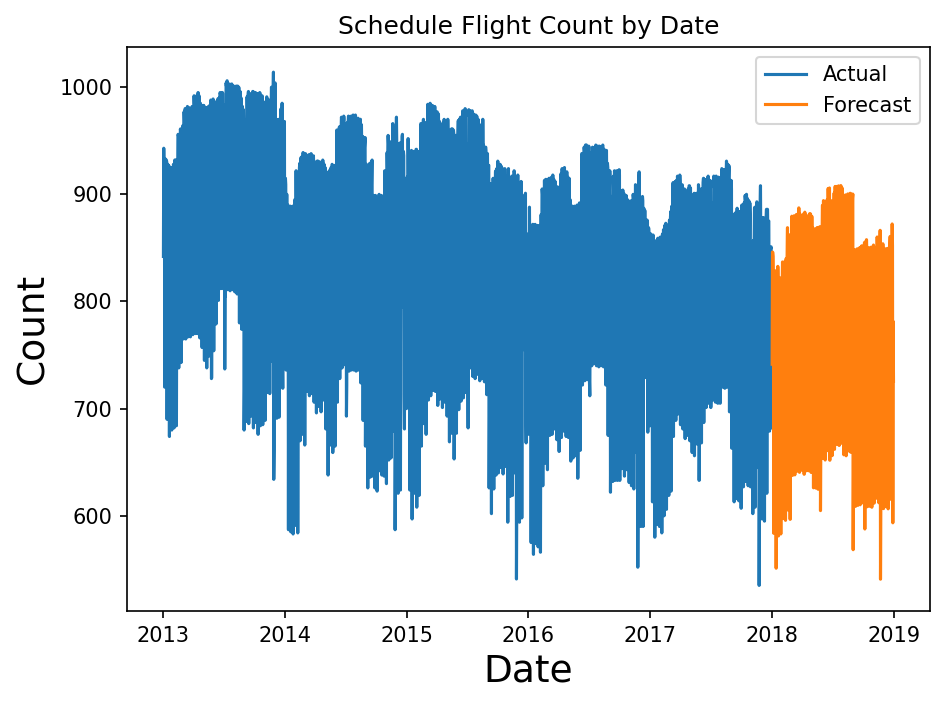

In [14]:
plot = sns.lineplot(df, x='date', y='count', label='Actual')
sns.lineplot(x=fdf.date, y=forecast_y, label='Forecast')
plot.set(title='Schedule Flight Count by Date', xlabel='Date', ylabel='Count');
plot.figure.savefig('forecast.png')